### User Inputs

In [1]:
retailer = 'pure'
offer_name = 'free coffee yellow'
measurment_period_days = 30

sql_flux = 'pure_txns.sql'
sql_retailer = 'pure_all.sql'

### Packages and definitions needed for python 

In [2]:
# install required packages
import pandas as pd
import numpy as np
from utils.database import query_from_file
import datetime
import time
import plotly.express as px
import psutil
from datetime import datetime, timedelta
from utils import style
import matplotlib
path = '/Users/jennamiles/Documents/credentials'

/Users/jennamiles/.pyenv/versions/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
#this is from database.py
#need to update in utils because of directory issue
import os
from psycopg2 import connect
from pandas import read_sql

def query(sql_statement: str, **kwargs):
    with open(f'{path}', 'r') as credentials:
        connection = connect(credentials.read())
        cursor = connection.cursor()

        if len(kwargs) > 0:
            dataframe = read_sql(sql_statement.format(**kwargs), connection)
        else:
            dataframe = read_sql(sql_statement, connection)

        assert len(dataframe) > 0, 'query returned no results'
        return dataframe
    
def query_from_file(sql_file: str, **kwargs):
    with open(sql_file, 'r') as f:
        return query(f.read(), **kwargs)

In [4]:
matplotlib.rcParams['font.sans-serif'] = 'Akkurat Pro'
matplotlib.rcParams['font.serif'] = 'Vesterbro'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = '15'

matplotlib.rcParams['figure.figsize'] = (50, 15)
matplotlib.rcParams['figure.titlesize'] = '25'

matplotlib.rcParams['axes.titlesize'] = '25'
matplotlib.rcParams['axes.labelsize'] = '15'
matplotlib.rcParams['axes.titlepad'] = '25'
matplotlib.rcParams['axes.labelpad'] = '30'
matplotlib.rcParams['xtick.labelsize'] = '15'
matplotlib.rcParams['ytick.labelsize'] = '20'

### Read in transactions for retailer

In [6]:
#read in pure data from SQL query:
start = time.time()
df = query_from_file(sql_flux)
df_all = query_from_file(sql_retailer)
end = time.time()
query_time = end-start
print(f"Queries took {query_time:.2f} seconds")

Query took 355.14 seconds


### Data pre-processing
- Creates new **date** variables that will be useful

In [7]:
#additional date columns that will be useful 
df['date'] = df['transaction_date'].dt.date
df['day'] = df['transaction_date'].dt.isocalendar().day
df['week'] = df['transaction_date'].dt.isocalendar().week
df['week_start'] = (df['transaction_date'] - pd.TimedeltaIndex(df['transaction_date'].dt.dayofweek, unit='D')).dt.date
df['month'] = df['transaction_date'].dt.month

- Change data types where necessary

In [8]:
#change price to a numeric variable 
df['price'] = pd.to_numeric(df['item_price'])

- Creates a variable that indicates the **receipt number** for that customer
- This will be used to segments new and existing customers
- Warning - we can only see if they are new customers within Flux, so they may have a receipt count of 1 even though transacted before 

In [9]:
df_receipts = df[['customer_id','receipt_id','total_amount','transaction_date','date','month','week','location_id']].drop_duplicates().sort_values(['customer_id','transaction_date'])
df_receipts['receipt_count'] = df_receipts.groupby(['customer_id'])['receipt_id'].cumcount()+1
df = pd.merge(df, df_receipts[['receipt_count','customer_id','receipt_id']], on = ['customer_id','receipt_id'], how = 'left' )

- identify transactions on the chosen offer
- save the receipts containing the offer to an array to reference another time
- useful for flux and all redemptions

In [10]:
df_offer = df[df['name'].str.lower() == offer_name].copy()
df_all_offer = df_all[df_all['name'].str.lower() == offer_name].copy()
redemption_receipts = df_offer['receipt_id'].unique()
redeemers = df_offer['customer_id'].unique()
redemption_count = len(redemption_receipts)
redeemer_count = len(redeemers)

- assign start and end dates of the offer to objects to reference in code
- assign the number of days, weeks and months an offer was live for to objects to reference in code

In [14]:
date_min = df_all_offer['adjusted_transaction_date'].min() 
date_max = df_all_offer['adjusted_transaction_date'].max()  
days_live = (date_max - date_min).days
weeks_live = round(np.floor(days_live/7))
months_live = round(np.floor(weeks_live/4))

- identify all transactions at retailer while the offer was live
- segment customers that transacted during the offer period into customers acquired on offer and previous customers = acquired_previous
- segment customers that transacted into new and existing before the offer period start date = new_existing
- segment customers into customers that redeemed the offer or not
- also going to provide a view of acquired, new_not_acquired, existing

In [15]:
df_live = df[(df['date']<=date_max) & (df['date']>=date_min)].copy()

new_customers = df_live[df_live.receipt_count== 1].customer_id.unique()
acquired_customers = df_live[(df_live['receipt_id'].isin(redemption_receipts))& (df_live.receipt_count==1)]['customer_id'].unique()

df_live['redemption_segment'] = np.where(df_live['customer_id'].isin(redeemers),'redeemer','non-redeemer')
df_live['acquired_previous'] = np.where(df_live['customer_id'].isin(acquired_customers),'acquired','previous')
df_live['new_existing'] = np.where(df_live['customer_id'].isin(new_customers),'new','existing')
df_live['acquired_new_existing'] = np.where(df_live['customer_id'].isin(acquired_customers),'acquired',df_live['new_existing'])
df_live['acquired_new_existing'] = df_live['acquired_new_existing'].str.replace('new','new_not_acquired')

- create a df that holds only the receipt information and not the sku data too, with segments included

In [16]:
df_live_receipts = df_live[['customer_id', 'receipt_id', 'total_amount', 'price', 'redemption_segment', 'acquired_previous', 'new_existing', 'acquired_new_existing','transaction_date','receipt_count','date','week_start']].copy().drop_duplicates()

- add in a variable that holds **basket size**
- don't want to include in basket size any freebies or £0 items, such as the milk chosen, or any discounts that aren't an item, such as 50p off for using a reusable cup
- it is tricky because the true offers, such as free coffe first appear as an item and then the price is taken off. 
- The item price being taken off should match that provided on the receipt for it to be an offer and not just a discounts, e.g. reusable cup 50p

In [17]:
# add a receipt_price_count variable, so can flag if multiple used on one receipt
df['receipt_price_count'] = df.groupby(['receipt_id','price']).cumcount()+1
#identify the discounts
discounts = pd.DataFrame(df[df['price']<0][['receipt_id','price','receipt_price_count']])
discounts['price'] = discounts['price']*-1
discounts['offer_flag'] = '1'
#reattach the discounts onto transactions to match the item where freebie has been given
#now anything bought on an offer should be flagged 
df = pd.merge(df, discounts, on=['receipt_id','price','receipt_price_count'], how = 'left')
df.fillna('0', inplace = True)
#count the paid-for items on each receipt
#this will still include the initial proe of items that were taken off the final receipt
receipt_item_count = pd.DataFrame(df[(df['price']>0) & (df['offer_flag']=='0')].groupby('receipt_id').count()['item_id']).reset_index()
receipt_item_count.columns = ['receipt_id','adjusted_basket_size']
#attach onto receipts from the offer period
df_live = pd.merge(df_live,receipt_item_count, on = 'receipt_id',how = 'left') 
df_live.fillna(0, inplace = True)

# Results


### Segment counts

In [18]:
customer_receipt_counts = df_live.groupby(['redemption_segment','acquired_previous','new_existing']).nunique()[['customer_id','receipt_id']]
customer_receipt_counts.columns = ['unique customers','unique receipts']
customer_receipt_counts

unique customers  \
redemption_segment acquired_previous new_existing                     
non-redeemer       previous          existing                  3220   
                                     new                       4371   
redeemer           acquired          new                         22   
                   previous          existing                    91   
                                     new                         45   

                                                   unique receipts  
redemption_segment acquired_previous new_existing                   
non-redeemer       previous          existing                15334  
                                     new                      7796  
redeemer           acquired          new                        55  
                   previous          existing                 1335  
                                     new                       509

### Segment percentages

- What percent of customers using the offer are acquired customers vs customers that had already transacted at the retailer?

In [19]:
customer_pcent = (customer_receipt_counts.loc['redeemer']['unique customers']/(customer_receipt_counts.loc['redeemer']['unique customers'].sum()))*100
print('The % split of redeemers by customer segment is:')
print(customer_pcent)

The % split of redeemers by customer segment is:
acquired_previous  new_existing
acquired           new             13.924051
previous           existing        57.594937
                   new             28.481013
Name: unique customers, dtype: float64


- what % of customers transacting per week at the retailer are new that week vs previous?
- use the previous 4 weeks worth of transactions prior to the offer
- we will use this as a baseline to compare the offer to

In [20]:
df_pre = df_receipts[df_receipts.date < date_min].copy()
baseline_pre = df_pre[df_pre['receipt_count']==1].groupby(['week','receipt_count']).nunique()[['customer_id']]/df_pre.groupby('week').nunique()[['customer_id']].tail(4)
baseline_new_pcent = baseline_pre['customer_id'].mean()*100
print(f'The baseline of transacting customers that are new per week is: {baseline_new_pcent:.2f}%')

The baseline of transacting customers that are new per week is: 68.35%


- *would be good here to know how much this varies - does the offer fall between 2sd of the ussual % customers? Is is truly different? or do we only care about having a comparison?*
- *or some sort of significance test*

In [74]:
#grab counts, ATF, ATV  and Basket Size per group 

#first group by customer
agg = df_live.groupby(['redemption_segment','acquired_previous','new_existing','customer_id']).agg({'receipt_id':['nunique']
                                                                                        ,'total_amount':['sum','mean']
                                                                                        ,'adjusted_basket_size':['mean']})
agg.columns=agg.columns.map('_'.join)
agg.columns = ['frequency','total_amount','amount','adjusted_basket_size']
agg.reset_index(inplace = True)
#then grab metrics
agg2 = agg.groupby(['redemption_segment','acquired_previous','new_existing']).agg({'customer_id'  : ['nunique']
                                                                    ,'frequency'  : ['mean','median']
                                                                    ,'total_amount': ['sum','mean','median']
                                                                    , 'amount':['mean','median']
                                                                    , 'adjusted_basket_size':['mean','median']
                                                                           })
agg2.columns=agg2.columns.map('_'.join)
agg2['weekly_ATF'] = agg2['frequency_median']/(days_live/7)
agg2['yearly_ATF'] = (agg2['frequency_median']/(days_live))*365
agg2['ATF_offer_period'] = agg2['frequency_median']
agg2['ATV'] = agg2['amount_median']/100 #using median as less sensitive to outliers
agg2['weekly_ACV'] = (agg2['total_amount_median']/(days_live/7))/100
agg2['ACV_offer_period'] = (agg2['total_amount_median'])/100
agg2['ABS'] = agg2['adjusted_basket_size_median']
summary_metrics = agg2[['customer_id_nunique','weekly_ATF','ATF_offer_period','ATV','weekly_ACV','ACV_offer_period','ABS','yearly_ATF']]

#view of just reeedemr and previous/ existing segmentation
agg3 = agg.groupby(['redemption_segment','acquired_previous']).agg({'customer_id'  : ['nunique']
                                                                    ,'frequency'  : ['mean','median']
                                                                    ,'total_amount': ['sum','mean','median']
                                                                    , 'amount':['mean','median']
                                                                    , 'adjusted_basket_size':['mean','median']
                                                                           })
agg3.columns=agg3.columns.map('_'.join)
agg3['weekly_ATF'] = agg3['frequency_median']/(days_live/7)
agg3['yearly_ATF'] = (agg3['frequency_median']/(days_live))*365
agg3['ATF_offer_period'] = agg3['frequency_median']
agg3['ATV'] = agg3['amount_median']/100 #using median as less sensitive to outliers
agg3['weekly_ACV'] = (agg3['total_amount_median']/(days_live/7))/100
agg3['ACV_offer_period'] = (agg3['total_amount_median'])/100
agg3['ABS'] = agg3['adjusted_basket_size_median']
summary_metrics2 = agg3[['customer_id_nunique','weekly_ATF','ATF_offer_period','ATV','weekly_ACV','ACV_offer_period','ABS','yearly_ATF']]

In [75]:
summary_metrics

customer_id_nunique  \
redemption_segment acquired_previous new_existing                        
non-redeemer       previous          existing                     3220   
                                     new                          4371   
redeemer           acquired          new                            22   
                   previous          existing                       91   
                                     new                            45   

                                                   weekly_ATF  \
redemption_segment acquired_previous new_existing               
non-redeemer       previous          existing        0.027778   
                                     new             0.013889   
redeemer           acquired          new             0.020833   
                   previous          existing        0.125000   
                                     new             0.083333   

                                                   ATF_offer_period       ATV  \
redemption_segment acquired_previous new_existing                               
non-redeemer       previous          existing                   2.0  5.120000   
                                     new                        1.0  4.950000   
redeemer           acquired          new                        1.5  3.387143   
                   previous          existing                   9.0  4.520612   
                                     new                        6.0  5.109070   

                                                   weekly_ACV  \
redemption_segment acquired_previous new_existing               
non-redeemer       previous          existing        0.257222   
                                     new             0.124722   
redeemer           acquired          new             0.267500   
                   previous          existing        1.029444   
                                     new             1.241111   

                                                   ACV_offer_period       ABS  \
redemption_segment acquired_previous new_existing                               
non-redeemer       previous          existing                 18.52  1.500000   
                                     new                       8.98  1.000000   
redeemer           acquired          new                      19.26  1.000000   
                   previous          existing                 74.12  1.454545   
                                     new                      89.36  1.681818   

                                                   yearly_ATF  
redemption_segment acquired_previous new_existing              
non-redeemer       previous          existing        1.448413  
                                     new             0.724206  
redeemer           acquired          new             1.086310  
                   previous          existing        6.517857  
                                     new             4.345238

In [76]:
summary_metrics2

customer_id_nunique  weekly_ATF  \
redemption_segment acquired_previous                                    
non-redeemer       previous                          7591    0.013889   
redeemer           acquired                            22    0.020833   
                   previous                           136    0.125000   

                                      ATF_offer_period       ATV  weekly_ACV  \
redemption_segment acquired_previous                                           
non-redeemer       previous                        1.0  4.983333    0.171944   
redeemer           acquired                        1.5  3.387143    0.267500   
                   previous                        9.0  4.772679    1.060417   

                                      ACV_offer_period       ABS  yearly_ATF  
redemption_segment acquired_previous                                          
non-redeemer       previous                      12.38  1.400000    0.724206  
redeemer           acquired                      19.26  1.000000    1.086310  
                   previous                      76.35  1.528571    6.517857

## Redemptions Card

In [174]:
#all redemptions
total_redemptions = len(df_offer)
total_redemptions_all = len(df_all_offer)
#all redeemers
total_cust = agg2.loc['redeemer'].customer_id_nunique.sum()
#all transactors:
total_transactors = agg2.customer_id_nunique.sum()
#redemptions per customer
redemptions_per_customer = total_redemptions/total_cust

#previous retailer customers
previous_volume = agg2.loc['redeemer'].loc['previous'].customer_id_nunique.sum()
#retailer acquisitions - made first transacgion on the offer
acquisitions_volume = agg2.loc['redeemer'].loc['acquired'].customer_id_nunique.sum()

#total new customers
new_volume = agg2.reset_index(['acquired_previous','redemption_segment']).loc['new'].customer_id_nunique.sum()
#total new redeemers
new_redeemers = agg2.loc['redeemer'].reset_index('acquired_previous').loc['new'].customer_id_nunique.sum()

#percentages
previous_pcent = (previous_volume/total_cust)*100
acquisitions_pcent = (acquisitions_volume/total_cust)*100
new_pcent = (new_volume/total_transactors)*100
baseline_diff = new_pcent - baseline_new_pcent
redemptions_scaler = round(total_redemptions_all/total_redemptions,4)

#print results
print(f'The total number of redemptions =  {total_redemptions}')
print(f'The total number of redemptions across unmatched transactions =  {total_redemptions_all}')
print('\n')
print(f'Redemptions scaler is {redemptions_scaler}')
print('\n')
print(f'The total number of unique customers that used the offer = {total_cust}')
print(f'Estimated number of unique customers that used the offer across retailer = {round(total_cust*redemptions_scaler)}')
print('\n')
print(f'The numer of redemptions per customer = {redemptions_per_customer:.2f}')
print('\n')
print(f'{acquisitions_pcent:.0f}% of redeemers ({acquisitions_volume} customers) are new customers that were acquired on the offer, meaning their first transaction was using the offer')
print(f'{previous_pcent:.0f}% of redeemers are previous customers')
print('\n')
print(f'The baseline % of weekly new customers is {baseline_new_pcent:.2f}% \n(This is the average % of customers that are new based on 4 weeks pre offer start)')
print(f'The % of weekly new customers during the offer period is {new_pcent:.2f}% ')
print('\n')
print(f'The offer period has an absolute % difference of {baseline_diff:.0f}% new customers compared to the baseline')

The total number of redemptions =  309
The total number of redemptions across unmatched transactions =  11248


Redemptions scaler is 36.4013


The total number of unique customers that used the offer = 158
Estimated number of unique customers that used the offer across retailer = 5751


The numer of redemptions per customer = 1.96


14% of redeemers (22 customers) are new customers that were acquired on the offer, meaning their first transaction was using the offer
86% of redeemers are previous customers


The baseline % of weekly new customers is 68.35% 
(This is the average % of customers that are new based on 4 weeks pre offer start)
The % of weekly new customers during the offer period is 57.27% 


The offer period has an absolute % difference of -11% new customers compared to the baseline


## Frequency Metrics

In [24]:
f_metrics = summary_metrics['weekly_ATF']

#we want ot aggreate just for redemption segment
#using median so that result is insensitive to outlier customers
ATF_redeemer = agg[agg['redemption_segment']=='redeemer']['frequency'].median()
ATF_non_redeemer = agg[agg['redemption_segment']=='non-redeemer']['frequency'].median()

ATF_redeemer_weekly = agg[agg['redemption_segment']=='redeemer']['frequency'].median()/(days_live/7)
ATF_non_redeemer_weekly = agg[agg['redemption_segment']=='non-redeemer']['frequency'].median()/(days_live/7)

print(f'Redeemers of the offer transacted on average {ATF_redeemer:.2f} times during the offer period')
print(f'Non-redeemers of the offer transacted on average {ATF_non_redeemer:.2f} times during the offer period')
print('\n')
print(f'Redeemers of the offer transacted on average {ATF_redeemer_weekly:.3f} times PER WEEK during the offer period')
print(f'Non-redeemers of the offer transacted on average {ATF_non_redeemer_weekly:.3f} times PER WEEK during the offer period')
print('\n')
print(f'Redeemers of the offer transacted on average {ATF_redeemer_weekly*52:.1f} times over a projected year')
print(f'Non-redeemers of the offer transacted on average {ATF_non_redeemer_weekly*52:.1f} times over a projected year')
print('\n')
print('More detailed breakdown of weekly ATF:')
print(f_metrics)
print('\n')

Redeemers of the offer transacted on average 6.50 times during the offer period
Non-redeemers of the offer transacted on average 1.00 times during the offer period


Redeemers of the offer transacted on average 0.090 times PER WEEK during the offer period
Non-redeemers of the offer transacted on average 0.014 times PER WEEK during the offer period


Redeemers of the offer transacted on average 4.7 times over a projected year
Non-redeemers of the offer transacted on average 0.7 times over a projected year


More detailed breakdown of weekly ATF:
redemption_segment  acquired_previous  new_existing
non-redeemer        previous           existing        0.027778
                                       new             0.013889
redeemer            acquired           new             0.020833
                    previous           existing        0.125000
                                       new             0.083333
Name: weekly_ATF, dtype: float64




## Retention graph

- Want to look at acquisitions vs those that are new in the time period to compare the repeat purcahse rate
- Give view of how many made repeat purcahses

In [25]:
#grab the customers in two segments:
df_repeat_subset = df_live[df_live.new_existing == 'new'][['acquired_previous','customer_id','date','receipt_count']].copy()
#acquisitions
df_repeat_subset['lagged_date'] = df_repeat_subset.sort_values(by = ['customer_id','date'],ascending = True).groupby('customer_id')['date'].shift(1)
df_repeat_subset['date_diff'] = (df_repeat_subset['date'] - df_repeat_subset['lagged_date']).dt.days
df_repeat_subset['week_diff'] = np.ceil(df_repeat_subset.date_diff/7)

- over 12 weeks what % of acquired vs new not acquired made repeat purcahses?
- volumes:

In [26]:
#restrict to 12 weeks after their first transaction
df_repeat = df_repeat_subset[df_repeat_subset['week_diff']<12].groupby(['acquired_previous','receipt_count']).nunique()['customer_id'].unstack()
df_repeat[[1,2,3,4,5,6,7,8,9,10]].fillna(0)

receipt_count,1,2,3,4,5,6,7,8,9,10
acquired_previous,,,,,,,,,,
acquired,22.0,11.0,7.0,4.0,4.0,3.0,2.0,1.0,1.0,0.0
previous,2016.0,1155.0,608.0,384.0,259.0,197.0,147.0,114.0,97.0,85.0


- as a percentage of those in each group:

In [27]:
df_repeat.div(df_repeat[1], axis=0)[[1,2,3,4,5,6,7,8,9,10]].fillna(0)*100


receipt_count,1,2,3,4,5,6,7,8,9,10
acquired_previous,,,,,,,,,,
acquired,100.0,50.000000,31.818182,18.181818,18.181818,13.636364,9.090909,4.545455,4.545455,0.00000
previous,100.0,57.291667,30.158730,19.047619,12.847222,9.771825,7.291667,5.654762,4.811508,4.21627


## Revenue Impact

### Existing customers

- Calculate the daily pre spend in existing customers (those that had transacted at retailer before offer period start)
- Limiting to a 90 days pre period to make spend uplift more relevant to their spend at time of offer start, rather than looking a full year prior

In [28]:
#during offer period
during_spend = agg[agg['new_existing']=='existing'].groupby('redemption_segment').agg({'total_amount':['mean','median','sum']})

#pre offer period
#first need to know the redemption segments they ended up in 
offer_period_segs = agg[['customer_id','redemption_segment']].drop_duplicates()
#by definition all customers in the pre offer period are in the existing segment but will need to attach on redemption segment to pre transactions
#might want to limit ot only look at a few months before, more representative of the customers recent spend?? Although could be prone to seasonality. 
pre_offer_transactions = df[(df['date']<date_min)& (df['date']>=(date_min - pd.Timedelta(90, unit='D')))][['customer_id','receipt_id','total_amount','date']].drop_duplicates()
pre_offer_seg = pd.merge(pre_offer_transactions,offer_period_segs, on = 'customer_id',how = 'left')
pre_offer_seg.fillna(0, inplace = True)
pre_spend = pre_offer_seg.groupby('redemption_segment').agg({'total_amount':['mean','median','sum']})
#need to be careful here with null values -> where customers do not transact in offer period 
#and with what type of average being used

#divide by the number of days the offer period was live and the number of days of pre period to make comparable
pre_days = (df_live.date.min() - pre_offer_transactions.date.min()).days

print(f'The number of days in the pre period is {pre_days}')
print(f'The number of days in the offer period is {days_live}')
print('\n')
print('Total amount per days pre:')
pre_spend_daily = (pre_spend/pre_days).loc[['redeemer','non-redeemer']]
print(pre_spend_daily)
print('\n')
print('Total amount per days offer:')
during_spend_daily = during_spend/days_live
print(during_spend_daily)

The number of days in the pre period is 90
The number of days in the offer period is 504


Total amount per days pre:
                   total_amount                        
                           mean    median           sum
redemption_segment                                     
redeemer                5.16355  4.277778   3387.288889
non-redeemer            5.62876  5.388889  64719.477778


Total amount per days offer:
                   total_amount                         
                           mean     median           sum
redemption_segment                                      
non-redeemer           9.356906   3.674603  30129.238095
redeemer              28.663549  14.706349   2608.382937


In [31]:
#count the existing redeemers
exisiting_redeemers = agg[(agg['new_existing']=='existing')& (agg['redemption_segment']=='redeemer')].customer_id.nunique()

#calculate change in spend for redeemers and non-redeemers
redeemer_change = during_spend_daily['total_amount']['median']['redeemer'] - pre_spend_daily['total_amount']['median']['redeemer']
pcent_redeemer_change = redeemer_change/(pre_spend_daily['total_amount']['median']['redeemer'])

non_redeemer_change = during_spend_daily['total_amount']['median']['non-redeemer'] - pre_spend_daily['total_amount']['median']['non-redeemer']
pcent_non_redeemer_change = non_redeemer_change/(pre_spend_daily['total_amount']['median']['non-redeemer'])

if pcent_redeemer_change**2 > pcent_non_redeemer_change**2:
    larger_smaller = 'larger'
else: 
    larger_smaller = 'smaller'
    
if pcent_redeemer_change > 0:
    increase_decrease = 'increase'
else:
    increase_decrease = 'decrease'

incr_pcent = pcent_redeemer_change-pcent_non_redeemer_change
avg_pre_spend_redeemer = pre_spend_daily['total_amount']['median']['redeemer']/100
incr_spend = (avg_pre_spend_redeemer * incr_pcent)

print('Existing Customers Incremental Spend \n')
print(f'The redeemers of the offer have a {larger_smaller} proportional {increase_decrease} in daily average spend than the non-redeemers between the pre period and offer period')
print(f'The perentage change in spend between periods is {pcent_redeemer_change*100:.0f}% in the redeemer group & {pcent_non_redeemer_change*100:.0f}% in the non-redeemer group')
#print(f'Incremental accounts for {incr_pcent*100:.0f}% of spend in the redeemer group')
print(f'The average pre spend per redeemer per day was £{avg_pre_spend_redeemer:.4f}, resulting in a daily incremental spend per redeemer of £{incr_spend:.4f}')
incr_spend_existing = incr_spend*exisiting_redeemers*days_live
print(f'Over the offer period of {days_live} days, this is a total incremental spend of £{incr_spend_existing:.0f} across the {exisiting_redeemers} customers')
print(f'Or £{(incr_spend_existing/exisiting_redeemers):.2f} per customer')

Existing Customers Incremental Spend 

The redeemers of the offer have a larger proportional increase in daily average spend than the non-redeemers between the pre period and offer period
The perentage change in spend between periods is 244% in the redeemer group & -32% in the non-redeemer group
The average pre spend per redeemer per day was £0.0428, resulting in a daily incremental spend per redeemer of £0.1179
Over the offer period of 504 days, this is a total incremental spend of £5407 across the 91 customers
Or £59.42 per customer


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


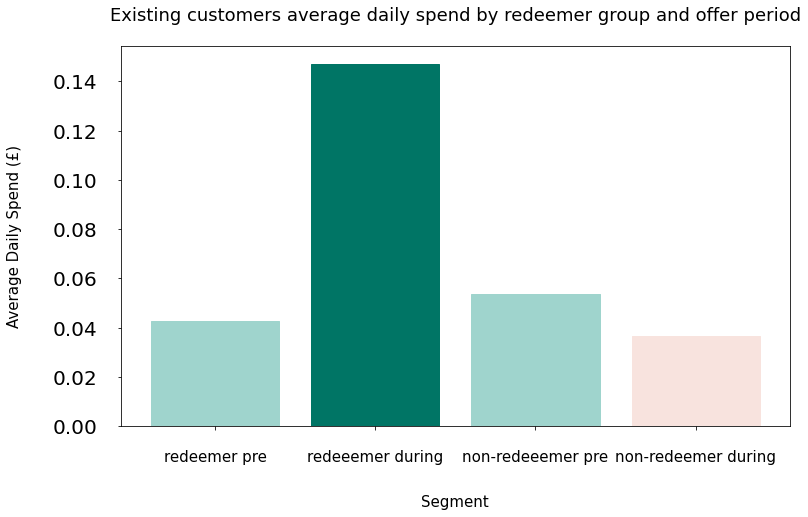

In [32]:
#quick plot of difference to help understanding
import matplotlib.pyplot as plt
plt.figure(figsize = (12,7))
rp = pre_spend_daily['total_amount']['median']['redeemer']/100
rd = during_spend_daily['total_amount']['median']['redeemer']/100
nrp = pre_spend_daily['total_amount']['median']['non-redeemer']/100
nrd = during_spend_daily['total_amount']['median']['non-redeemer']/100
x = ['redeemer pre','redeeemer during','non-redeeemer pre','non-redeemer during']
y = pd.Series([rp,rd,nrp,nrd])

chart = plt.bar(x,y)
chart[0].set_color('mint')
chart[1].set_color('green')
chart[2].set_color('mint')
chart[3].set_color('pink')
plt.title('Existing customers average daily spend by redeemer group and offer period', size = 18)
plt.ylabel('Average Daily Spend (£)', size = 15)
plt.xlabel('Segment', size = 15)
plt.show()

- *Is the difference significant?*



### New customers (2+ transactions)
- This is a comparison in revenue impact between the new customers that redemeed the offer and new customers that did not redeem the offer
- We are only considering new customers with 2+ transactions because acquisition value is taken into consideration separately. 
- Comparing all of the new non-redeemers with just the new non-acquisisition redeemers, we are already selecting only redeemers with 2+ transactions (otherwise they would be acquisition redeemers)
- Who are the customers that were new in offer period and made 2+ transactions? How many are there?

In [33]:
new_cust_2plus = df_live[(df_live.new_existing=='new')&(df_live['receipt_count']>=2)].customer_id.unique()

- How many days were the new customers live for during our offer period by redemption segment?

In [46]:
#when did the customers first transact in the offer period
new_cust_first_txn = df_live[(df_live.customer_id.isin(new_cust_2plus))&(df_live['receipt_count']==1)][['customer_id','date','redemption_segment']].copy()
#how many days active were they
new_cust_first_txn['days_active'] = (pd.to_datetime(date_max).date()- new_cust_first_txn['date']).astype('timedelta64[D]')
#what is the average active days for new customers in each redemption group 
new_days_active = new_cust_first_txn.groupby('redemption_segment').agg({'days_active':['mean','median'],'customer_id':['nunique']})

In [47]:
new_days_active

days_active        customer_id
                          mean median     nunique
redemption_segment                               
non-redeemer        382.684285  434.0        1245
redeemer            342.322034  398.0          56

- How much did the new customers spend during the offer live period? Split by redemption group

In [48]:
during_spend_new = agg[agg.customer_id.isin(new_cust_2plus)].groupby('redemption_segment').agg({'total_amount':['mean','median','sum'],'customer_id':['nunique']})

In [49]:
during_spend_new

total_amount                    customer_id
                            mean  median        sum     nunique
redemption_segment                                             
non-redeemer         3732.816064  2272.0  4647356.0        1245
redeemer            11337.392857  6832.0   634894.0          56

- How much spend in this per day, considering how many days they were active for during offer live period (convert to £)?

In [50]:
daily_avg_spend_new = (during_spend_new['total_amount']['median']/new_days_active['days_active']['median'])/100
pd.DataFrame(daily_avg_spend_new)

,median
redemption_segment,
non-redeemer,0.052350
redeemer,0.171658


- What is the incremental daily spend between new redeemer and new non-redeemers?

In [51]:
daily_incr_new = (daily_avg_spend_new['redeemer'] - daily_avg_spend_new['non-redeemer'])
daily_incr_new

0.11930806104253991

- What does this total over a the number of days they customers were active for on average in the redeemer group?

In [52]:
incr_spend_new = daily_incr_new*(new_days_active['days_active']['median']['redeemer'])
incr_spend_new

47.48460829493089

- How many redeemers are in this group?

In [53]:
#grab the numer of redeemers in 2+ category
new_cust_2plus_count = new_days_active.loc['redeemer'].customer_id.values[0]

In [54]:
new_cust_2plus_count

56.0

In [55]:
incr_spend_new_total = incr_spend_new*new_cust_2plus_count

- Print results for easy reading

In [56]:
print(f'For new customers, daily average incremetal spend was £{daily_incr_new:.2f} in the redeemer group')
print(f'')
print(f'Over the offer period, this is a total incremental spend of £{incr_spend_new_total:.2f} across the {new_cust_2plus_count:.0f} redeemers')
print(f'Or £{incr_spend_new_total/new_cust_2plus_count:.2f} per customer')

For new customers, daily average incremetal spend was £0.12 in the redeemer group

Over the offer period, this is a total incremental spend of £2659.14 across the 56 redeemers
Or £47.48 per customer


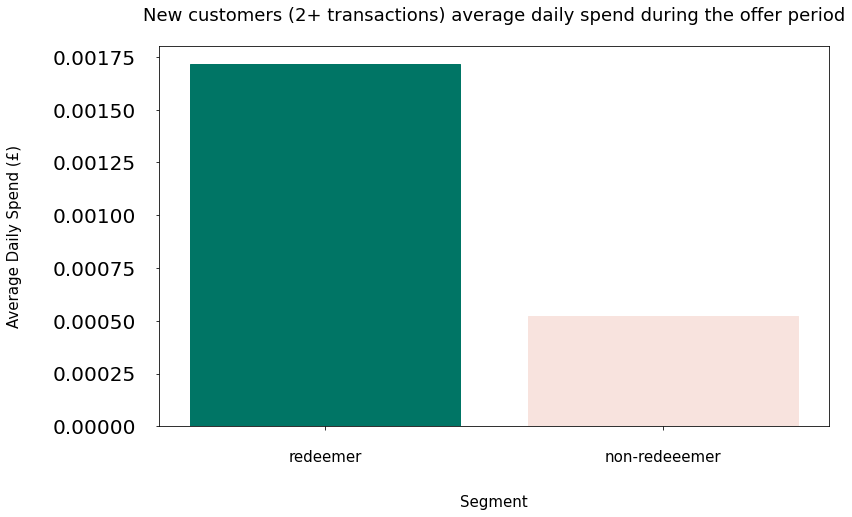

In [57]:
#quick plot of difference to help understanding

plt.figure(figsize = (12,7))
rd = daily_avg_spend_new['redeemer']/100
nrd = daily_avg_spend_new['non-redeemer']/100
x = ['redeemer','non-redeeemer']
y = pd.Series([rd,nrd])

chart = plt.bar(x,y)
chart[0].set_color('green')
chart[1].set_color('pink')
plt.title('New customers (2+ transactions) average daily spend during the offer period', size = 18)
plt.ylabel('Average Daily Spend (£)', size = 15)
plt.xlabel('Segment', size = 15)

plt.show()

## Acquired customers
spend of acquired customers over measurement period

- for the acquired customers, what was the date of their first transaction
- how many days over the offer period were they active (i.e. how many days after their first transaction)?


In [62]:
acquired = agg[agg['acquired_previous']=='acquired']
acquired_count = acquired.customer_id.nunique()
first_date = pd.DataFrame(df_live[df_live['acquired_previous']=='acquired'].groupby('customer_id').date.min())
acquired_df = pd.merge(acquired,first_date, on = 'customer_id', how = 'left')
acquired_df['max_date'] = pd.to_datetime(date_max).date()
acquired_df['date_diff'] = (acquired_df.max_date - acquired_df.date).dt.days
aquisition_avg_spend_daily = ((acquired_df['total_amount']/acquired_df['date_diff'])).median()/100
#what is this over a projected customer lifecycle for the retailer?, use 1 year for now 
#probably better to sit at start of code as separate calculation
lifecycle_days = 360
aquisition_avg_spend_projected = aquisition_avg_spend_daily*360
#what is this in total for the volume of acquisition customers?
aquisition_total_spend_projected = aquisition_avg_spend_projected*acquired_count

print(aquisition_avg_spend_daily)
print(aquisition_avg_spend_projected)
print(aquisition_total_spend_projected)

0.05374730409777139
19.3490294751977
425.6786484543494


In [63]:
during_spend_acquired = agg[agg['acquired_previous']=='acquired']['total_amount'].sum()
acquired_cust = agg[agg['acquired_previous']=='acquired'].nunique()['customer_id']

print(f'For aquired customers, all spend is attributed to the offer')
print(f'Assumption is that the offer drove them to start transacting with the retailer')
print('\n')
print(f'Over the projected customer lifecycle of {lifecycle_days} days, this is a total spend of £{aquisition_total_spend_projected:.2f} across the {acquired_count:.0f} customers')
print(f'Or £{aquisition_avg_spend_projected:.2f} per customer')
print(f'Or £{aquisition_avg_spend_daily:.2f} per customer per day')

For aquired customers, all spend is attributed to the offer
Assumption is that the offer drove them to start transacting with the retailer


Over the projected customer lifecycle of 360 days, this is a total spend of £425.68 across the 22 customers
Or £19.35 per customer
Or £0.05 per customer per day


### Note:
- above acquisition method doesn't take into account the 'slowing down' of spend when making a spend projection over X days
- this may need changing as for short offers, will assume spend over longer period of time will maintain the same level as when the customer first joins and is mmore engaged, likely to fall in reality
- instead could look at spend from acquired 30 days after their first transaction and project LTV based on that value per customer
- this is moving into the customer segment predictions we want to do so will wait until I get to that to amend method.


## Revenue Impact and ROI calculations

### Revenue impact for previous customers (Existing + New)

In [64]:
previous_revenue = incr_spend_new_total + incr_spend_existing 
previous_revenue_avg = previous_revenue/(exisiting_redeemers+new_cust_2plus_count)

print(f'The total incremental revenue from this offer for previous customers over the offer period is £{previous_revenue:.0f}')
print(f'Per redeemer this is £{previous_revenue_avg:.2f}')

The total incremental revenue from this offer for previous customers over the offer period is £8066
Per redeemer this is £54.87


### Cost for previous customers

In [65]:
previous_redeemer_receipts = df_live[(df_live.acquired_previous.isin(['previous']))&(df_live.redemption_segment.isin(['redeemer']))]['receipt_id'].unique()

previous_cost = (df_offer[df_offer['receipt_id'].isin(previous_redeemer_receipts)]['price']*-1).sum()/100
previous_cost_avg = previous_cost/(exisiting_redeemers+new_cust_2plus_count)


print(f'The total discount given to previous customers out over the offer measurement period is £{previous_cost}')
print(f'Per redeemer this is £{previous_cost_avg:.2f}')

The total discount given to previous customers out over the offer measurement period is £785.89
Per redeemer this is £5.35


### ROI for previous customers

In [66]:
roi_previous = previous_revenue_avg/previous_cost_avg
roi_previous

10.263811378577083

### Revenue impact for acquired customers 

In [67]:
acquired_revenue = aquisition_total_spend_projected
print(f'The total acquisition revenue from this offer over period is £{acquired_revenue:.0f}')

The total acquisition revenue from this offer over period is £426


### Cost for acquired

In [68]:
#cost for acquired:
acquired_receipts = df_live[df_live['acquired_previous'] == 'acquired']['receipt_id'].unique()

acquired_cost = (df_offer[df_offer['receipt_id'].isin(acquired_receipts)]['price']*-1).sum()/100
acquired_cost_avg = acquired_cost/acquired_count

print(f'The total discount given out to acquired customers over the offer measurement period is £{acquired_cost}')
print(f'Per redeemer this is £{acquired_cost_avg:.2f}')

The total discount given out to acquired customers over the offer measurement period is £104.39
Per redeemer this is £4.75


### ROI for acquired customers

In [69]:
roi_acquired = (acquired_revenue/acquired_cost)
roi_acquired

4.077772281390453

## ATV

In [70]:
v_metrics = agg2['ATV']

agg
ATV_redeemer = agg[agg['redemption_segment']=='redeemer']['amount'].median()/100
ATV_non_redeemer = agg[agg['redemption_segment']=='non-redeemer']['amount'].median()/100

print(f'Redeemers have an average transaction value of £{ATV_redeemer:.2f} during the offer period')
print(f'Non-redeemers have an average transaction value of £{ATV_non_redeemer:.2f} time during the offer period')
print('\n')

print('More detailed breakdown of ATV:')
print(v_metrics)
print('\n')

Redeemers have an average transaction value of £4.70 during the offer period
Non-redeemers have an average transaction value of £4.98 time during the offer period


More detailed breakdown of ATV:
redemption_segment  acquired_previous  new_existing
non-redeemer        previous           existing        5.120000
                                       new             4.950000
redeemer            acquired           new             3.387143
                    previous           existing        4.520612
                                       new             5.109070
Name: ATV, dtype: float64




- What is the average transaction value of redeemers?

In [71]:
agg[agg['redemption_segment']=='redeemer']['amount'].median()/100

4.697618664521319

- What is the ATV of acquired vs previous redeemers?

In [89]:
summary_metrics2.loc['redeemer'][['ATV']]

,ATV
acquired_previous,
acquired,3.387143
previous,4.772679


## Basket Size

In [90]:
#now can summarise by segments the average basket size 
b_metrics = summary_metrics['ABS']

ABS_redeemer = agg[agg['redemption_segment']=='redeemer']['adjusted_basket_size'].median()
ABS_non_redeemer = agg[agg['redemption_segment']=='non-redeemer']['adjusted_basket_size'].median()

print('Excluding the item on offer from the basket:')
print(f'Redeemers have an average basket size of {ABS_redeemer:.2f} during the offer period')
print(f'Non-redeemers have an average basket size of {ABS_non_redeemer:.2f} time during the offer period')
print('\n')

print('More detailed breakdown of Basket Size:')
print(b_metrics)
print('\n')

Excluding the item on offer from the basket:
Redeemers have an average basket size of 1.49 during the offer period
Non-redeemers have an average basket size of 1.40 time during the offer period


More detailed breakdown of Basket Size:
redemption_segment  acquired_previous  new_existing
non-redeemer        previous           existing        1.500000
                                       new             1.000000
redeemer            acquired           new             1.000000
                    previous           existing        1.454545
                                       new             1.681818
Name: ABS, dtype: float64




## Time of Day/ Day of Week Redemption

- Add required day and time variables

In [103]:
df_live['weekday_name'] = df_live['transaction_date'].dt.day_name()
df_live['weekday'] = df_live['transaction_date'].dt.weekday
df_live['time_hour'] = df_live['transaction_date'].dt.hour

- What day was the most popular overall?

In [104]:
days = pd.DataFrame(df_live[df_live.receipt_id.isin(redemption_receipts)].groupby(['weekday','weekday_name']).nunique()['receipt_id'])
days.columns = ['unique_receipts']
days.reset_index('weekday', drop = True, inplace = True)
top_day = days.sort_values(by = 'unique_receipts',ascending = False).head(1)
print(f'Overall, the most popular day to redeem is {top_day.index.values[0]}')

Overall, the most popular day to redeem is Tuesday


- Overlay the time of day from all redemptions to see if distribution matches

In [151]:
df_all_offer.head()
df_all_offer['weekday_name'] = df_all_offer['adjusted_transaction_date'].dt.day_name()
df_all_offer['weekday'] = df_all_offer['adjusted_transaction_date'].dt.weekday
df_all_offer['time_hour'] = df_all_offer['adjusted_transaction_date'].dt.hour
days_all = pd.DataFrame(df_all_offer.groupby(['weekday','weekday_name']).nunique()['txn_id'])
number, top_day_all = days_all.sort_values(by = 'txn_id',ascending = False).head(1).index.values[0]
print(f'Overall, the most popular day to redeem is {top_day_all}')

Overall, the most popular day to redeem is Wednesday


**Note: result changes when looking at all redemptions, use all redemptions result if only quoting one metric for most popular day of week?**

- What day was the most popular for acquired customers vs existing customers?

In [105]:
#split by new and existing redeemers
days_seg = pd.DataFrame(df_live[df_live.receipt_id.isin(redemption_receipts)].groupby(['acquired_previous','weekday','weekday_name']).nunique()['receipt_id'])
days_seg.columns = ['unique_receipts']
days_seg.reset_index('weekday', drop = True, inplace = True)
top_day_previous = days_seg.loc['previous'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]
top_day_acquired = days_seg.loc['acquired'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]
print(f'The most popular day for previous customers is {top_day_previous}')
print(f'The most popular day for acquired customers is {top_day_acquired}')

The most popular day for previous customers is Tuesday
The most popular day for acquired customers is Thursday


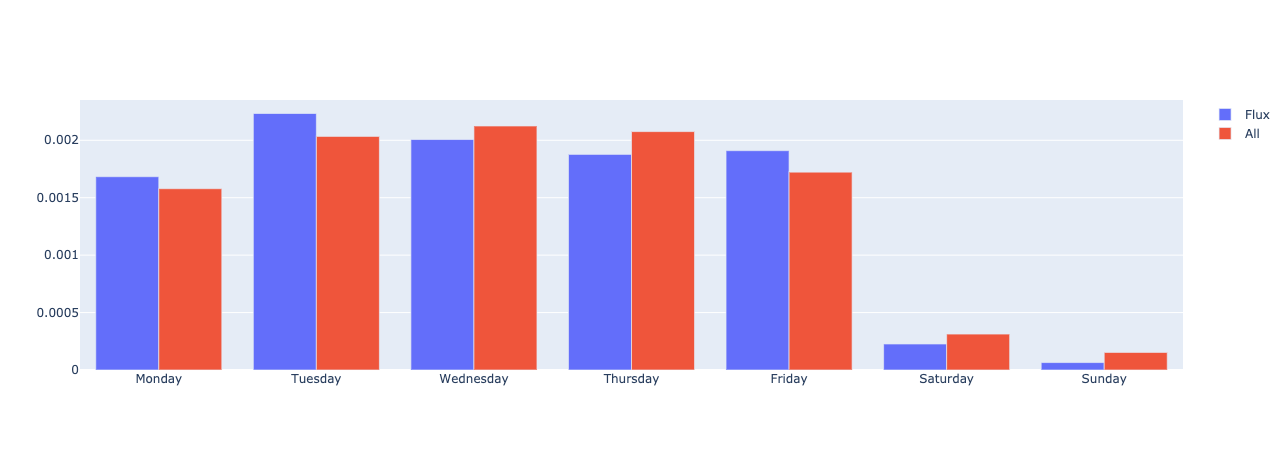

In [140]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Flux', x=days.index.values, y=days['unique_receipts']/(sum(days['unique_receipts'])*100)),
    go.Bar(name='All', x=days.index.values, y=days_all['txn_id']/(sum(days_all['txn_id'])*100))
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()


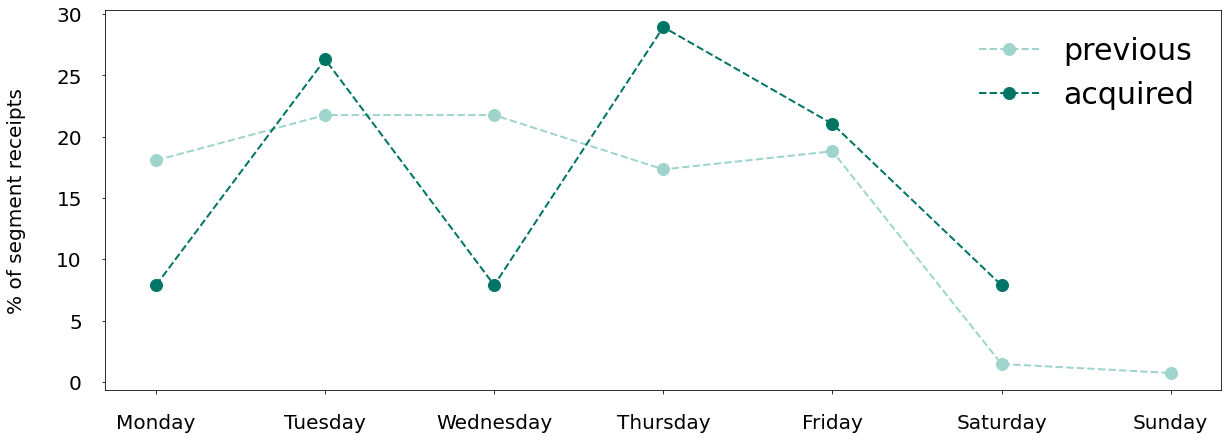

In [147]:
plt.figure(figsize = (20,7))
x1 = days_seg.loc['previous'].index.values
y1 = ((days_seg.loc['previous']/days_seg.loc['previous'].sum())*100)['unique_receipts']
x2 = days_seg.loc['acquired'].index.values
y2 = ((days_seg.loc['acquired']/days_seg.loc['acquired'].sum())*100)['unique_receipts']
plt.plot(x1,y1,color = 'mint', label = 'previous',marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(x2,y2,color = 'green', label = 'acquired',marker='o', linestyle='dashed',linewidth=2, markersize=12)
#plt.title('Offer redemptions by day of week and segment', size = 40, pad = 10)
plt.legend(fontsize = 30)
plt.ylabel('% of segment receipts', size = 20)
plt.show()

- How many redempetions were made for each hour?

In [152]:
hours = df_live[df_live.receipt_id.isin(redemption_receipts)].groupby(['time_hour']).nunique()['receipt_id']

In [153]:
hours.columns = ['unique_receipts']
top_hour = hours.sort_values(ascending = False).head(1)
print(f'The most popular hour is {top_hour.index.values[0]}')

The most popular hour is 8


- see what this is for all retailer redemptions

In [156]:
hours_all = df_all_offer.groupby(['time_hour']).nunique()['txn_id']
top_hour_all = hours_all.sort_values(ascending = False).head(1)
print(f'The most popular hour is {top_hour_all.index.values[0]}')

The most popular hour is 7


**Note: Again, the most popular hour has changed by using all redemptions, so use this if not looking by segment**

In [159]:
hours

time_hour
5      5
6     15
7     41
8     72
9     43
10    20
11    15
12    43
13    25
14    13
15     6
16     3
17     5
18     3
Name: receipt_id, dtype: int64

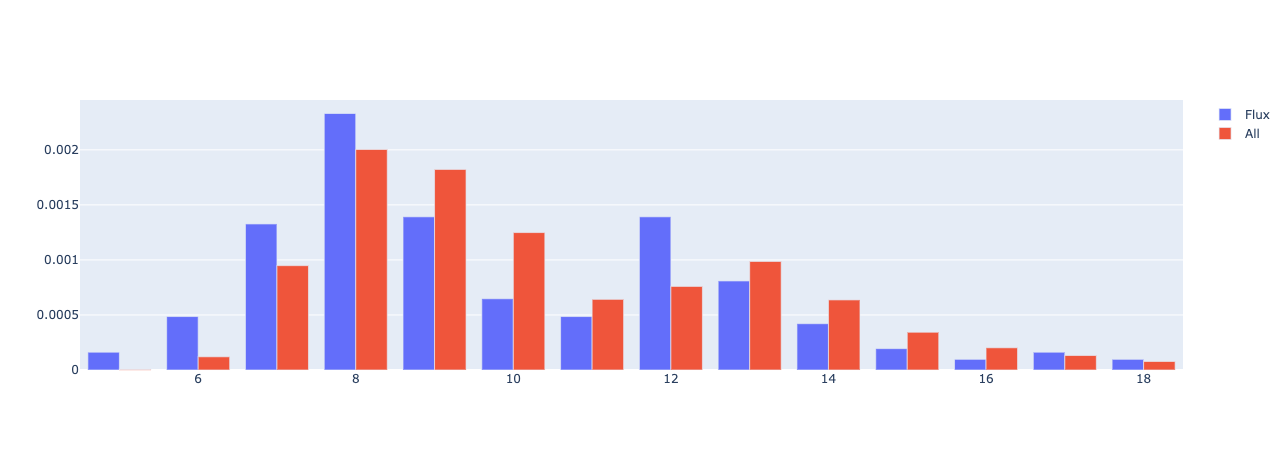

In [162]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Flux', x=hours.index.values, y=hours/(sum(hours)*100)),
    go.Bar(name='All', x=hours.index.values, y=hours_all/(sum(hours_all)*100))
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()


In [ ]:
#split by new and existing redeemers
hours_seg = pd.DataFrame(df_live[df_live.receipt_id.isin(redemption_receipts)].groupby(['acquired_previous','time_hour']).nunique()['receipt_id'])
hours_seg.columns = ['unique_receipts']
top_hour_previous = hours_seg.loc['previous'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]
top_hour_acquired = hours_seg.loc['acquired'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]

print(f'The most popular hour of day for previous customers is {top_hour_previous}')
print(f'The most popular hour of day for acquired customers is {top_hour_acquired}')

In [ ]:
x1 = hours_seg.loc['previous'].index.values
y1 = ((hours_seg.loc['previous']/hours_seg.loc['previous'].sum())*100)['unique_receipts']
x2 = hours_seg.loc['acquired'].index.values
y2 = ((hours_seg.loc['acquired']/hours_seg.loc['acquired'].sum())*100)['unique_receipts']
plt.plot(x1,y1,color = 'mint', label = 'previous',marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(x2,y2,color = 'green', label = 'acquired',marker='o', linestyle='dashed',linewidth=2, markersize=12)
#plt.title('Offer redemptions by day of week and segment', size = 40, pad = 10)
plt.legend(fontsize = 30)
plt.ylabel('% of segment receipts', size = 30)
plt.show()

In [ ]:
#matrix of day and hour

day_hours = pd.DataFrame(df_live[df_live.receipt_id.isin(redemption_receipts)].groupby(['weekday','weekday_name','time_hour']).nunique()['receipt_id'])
day_hours.columns =['unique_receipts']
#day_hours.reset_index('weekday',drop=True,inplace = True)
day_hours_unstack = day_hours.unstack().fillna(0)
day_hours_unstack.reset_index('weekday',drop=True,inplace = True)

In [ ]:
day_hours_unstack.style.background_gradient(cmap='BuGn', axis = None).set_precision(0)

- do the heatmatrix for day of week and time for the unmatched transactions instead 

In [164]:
# do for all transactions insteasd of flux 
day_hours = pd.DataFrame(df_all_offer.groupby(['weekday','weekday_name','time_hour']).nunique()['txn_id'])
day_hours_unstack = day_hours.unstack().fillna(0)
day_hours_unstack.reset_index('weekday',drop=True,inplace = True)

day_hours_unstack.style.background_gradient(cmap='BuGn', axis = None).set_precision(0)

## Repeat Redemptions
### Offer Repeat Rate

In [ ]:
redemption_receipts_df = pd.DataFrame(df_live[df_live.receipt_id.isin(redemption_receipts)].groupby(['acquired_previous','customer_id'])['receipt_id'].nunique().reset_index())

- What % of acquired and previous redeemers made a second redemption?

In [ ]:
(redemption_receipts_df[redemption_receipts_df['receipt_id']>1].groupby('acquired_previous').nunique()['customer_id']/redemption_receipts_df.groupby('acquired_previous').count()['customer_id'])*100